In [1]:
import json

# Đọc dữ liệu từ file JSON
with open("label.json", "r") as file:
    data = json.load(file)

# Lưu vào labels và group_label từ dữ liệu JSON
labels = data['data']['labels']
group_label = data['data']['group_label']

# Kiểm tra kết quả
print("Labels:", labels)
print("Group Labels:", group_label)


Labels: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Group Labels: {'Person': ['person'], 'Vehicle': ['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat'], 'Tr

In [5]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
import json
from tqdm import tqdm
import shutil


def read_json(json_path):
    # Đọc dữ liệu từ file JSON
    with open(json_path, "r") as file:
        data = json.load(file)

    # Lưu vào labels và group_label từ dữ liệu JSON
    labels = data['data']['labels']
    group_label = data['data']['group_label']
    return labels, group_label

def get_all_image_files(root_folder):
    # Các định dạng ảnh thường gặp
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff','.JPG'}
    image_files = []
    
    # Sử dụng os.walk để đệ quy qua tất cả các thư mục và file
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            # Kiểm tra xem file có phải là file ảnh không
            if os.path.splitext(filename)[1].lower() in image_extensions:
                image_files.append(os.path.join(dirpath, filename))
    return image_files

def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf, verbose=False)
    else:
        results = chosen_model.predict(img, conf=conf, verbose=False)

    return results

def predict_and_detect(chosen_model, img, classes=[], conf=0.5, rectangle_thickness=2, text_thickness=1):
    results = predict(chosen_model, img, classes, conf=conf)
    for result in results:
        for box in result.boxes:
            cv2.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                          (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), rectangle_thickness)
            cv2.putText(img, f"{result.names[int(box.cls[0])]}",
                        (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), text_thickness)
    return img, results
def find_group_for_label(label_name,group_label_dict):
    for group, labels in group_label_dict.items():
        if label_name in labels:
            return group
    return 'Unknown'


def sort_bb_group(results, top, group_label):
    areas_bb_with_labels = []
    if not results or len(results) == 0:
        return areas_bb_with_labels
    labels_name=results[0].names
    labels_name = list(labels_name.values())
    labels = results.boxes.cls
    bbs = results.boxes.xyxy
    for bb, label in zip(bbs, labels):
        x, y, x_, y_ = bb
        area = (x_ - x) * (y_ - y)  
        area = int(area.item()) 
        areas_bb_with_labels.append((area, int(label.item()))) 
    areas_bb_with_labels = sorted(areas_bb_with_labels, key=lambda x: x[0], reverse=True)
    top_areas_bb_with_labels = areas_bb_with_labels[:top]
    top_areas_with_group_labels = []
    for area, label in top_areas_bb_with_labels:
        label_name = labels_name[label] 
        group = find_group_for_label(label_name,group_label)
        top_areas_with_group_labels.append((area, label_name, group))
    return top_areas_with_group_labels

def calculate_total_area_by_group(output):
    group_area_totals = {}
    for area, label, group in output:
        if group in group_area_totals:
            group_area_totals[group] += area
        else:
            group_area_totals[group] = area 

    return group_area_totals

def calculate_total_area_by_group(output):
    group_area_totals = {}
    for area, label, group in output:
        if group in group_area_totals:
            group_area_totals[group] += area
        else:
            group_area_totals[group] = area 

    return group_area_totals

def get_label(group_area_totals):
    first_key = next(iter(group_area_totals), "Tools & Other")
    return first_key

def main(root_path, target, model_name, device, label,group_label):
    model = YOLO(model_name).to(device)  # Tải model
    list_img = get_all_image_files(root_path)  # Lấy danh sách tất cả các file ảnh

    # Thêm tqdm để hiển thị tiến trình của quá trình lặp qua các ảnh
    for img_path in tqdm(list_img, desc="Processing Images"):
        img = cv2.imread(img_path)
        img, result = predict_and_detect(model, img, [], 0.6)  # Dự đoán và phát hiện
        ar = sort_bb_group(result[0], 6, group_label)  # Sắp xếp bounding box
        re = calculate_total_area_by_group(ar)  # Tính tổng diện tích theo group
        group = next(iter(re), "no_label")  # Lấy group đầu tiên hoặc "no_label" nếu không có
        mkd = f"mkdir -p {target}/{group}"  # Tạo thư mục đích
        !{mkd}  # Tạo thư mục (có thể thay bằng os.makedirs nếu không sử dụng IPython)
        img_name = img_path.split("/")[-1]  # Lấy tên file ảnh
        destination_path = f"{target}/{group}/{img_name}"  # Đường dẫn đích
        shutil.copyfile(img_path, destination_path)  # Sao chép ảnh đến đích

    print("Processing completed.")

    
    


In [6]:
root_path="/Users/mac/Dev/Large_project/data/tiny_coco_dataset/tiny_coco/train2017"
target="/Users/mac/Dev/Large_project/Target"
model_name="yolov10x"
device="mps"
label, group_label= read_json("label.json")
main(root_path,target,model_name,device, label, group_label)

Processing Images: 100%|██████████| 50/50 [00:22<00:00,  2.18it/s]

Processing completed.


In [13]:
import shutil
for img_path in list_img:
    img=cv2.imread(img_path)
    img,result=predict_and_detect(model,img,[],0.6)
    ar=sort_bb_group(result[0],6,group_label)
    re=calculate_total_area_by_group(ar)
    group = next(iter(re))
    mkd=f"mkdir ./Target/{group}"
    !{mkd}
    img_name=img_path.split("/")[-1]
    destination_path=f"./Target/{group}/{img_name}"
    shutil.copyfile(img_path, destination_path)
    



0: 640x480 9 spoons, 1 bowl, 5 chairs, 1 dining table, 504.7ms
Speed: 9.1ms preprocess, 504.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 480)
mkdir: ./Target/Home: File exists

0: 640x576 2 persons, 2 tvs, 2 mouses, 3 keyboards, 128.8ms
Speed: 3.6ms preprocess, 128.8ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 576)
mkdir: ./Target/Person: File exists

0: 640x480 1 bottle, 1 toilet, 1 sink, 95.8ms
Speed: 2.3ms preprocess, 95.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
mkdir: ./Target/Home: File exists

0: 448x640 1 toilet, 95.5ms
Speed: 2.4ms preprocess, 95.5ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)
mkdir: ./Target/Home: File exists

0: 448x640 1 person, 1 elephant, 76.2ms
Speed: 2.0ms preprocess, 76.2ms inference, 70.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x480 (no detections), 167.3ms
Speed: 2.1ms preprocess, 167.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 48

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
import shutil

# Đường dẫn đến file nguồn và file đích
source_path = "path/to/source/file.txt"
destination_path = "path/to/destination/folder/file.txt"

# Sao chép file từ source_path đến destination_path
shutil.copyfile(source_path, destination_path)

print(f"File đã được sao chép từ {source_path} đến {destination_path}")


In [9]:
re=calculate_total_area_by_group(ar)
re.items

{'Vehicle': 14614, 'Person': 10034}

In [20]:
group,_=re.items()
group[0]

'Person'

In [7]:
ar

[(8537, 'car', 'Vehicle'),
 (4679, 'person', 'Person'),
 (3231, 'car', 'Vehicle'),
 (2846, 'motorcycle', 'Vehicle'),
 (2713, 'person', 'Person'),
 (2642, 'person', 'Person')]

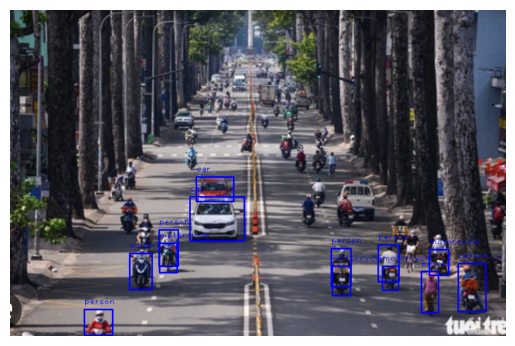

In [37]:
import matplotlib.pyplot as plt
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off') 
plt.show()
